In [1]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, log_loss
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
import category_encoders as ce
from numpy.testing import assert_almost_equal
from functools import reduce
import matplotlib.pyplot as plt
import time
from category_encoders.binary import BinaryEncoder

In [15]:
import kaggle

In [17]:
!kaggle datasets download -d ntnu-testimon/paysim1

100%|████████████████████████████████████████| 182M/182M [00:54<00:00, 3.67MB/s]



In [ ]:
url = "PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(url)
df.drop('nameOrig', inplace=True, axis=1)

In [5]:
encoders = Pipeline([
                ('binary', BinaryEncoder(cols=['nameDest'])),
                ('onehot', ce.OneHotEncoder(use_cat_names=True,cols=['type']))
            ])
df_ = encoders.fit_transform(df)
df_.head()

,type_PAYMENT,type_TRANSFER,type_CASH_OUT,type_DEBIT,type_CASH_IN,type_-1,nameDest_0,nameDest_1,nameDest_2,nameDest_3,...,nameDest_21,nameDest_22,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,0,0,0,0,0,0,0,0,0,...,0,1,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,1,1,1,181.00,181.0,0.00,0.0,0.0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [6]:
dependent = 'isFraud'

In [7]:
continuous_features = df_.drop(dependent, axis=1).select_dtypes(include='float').columns
discrete_features = df_.drop(dependent, axis=1).select_dtypes(include='int').columns

assert_almost_equal(len(continuous_features) + len(discrete_features) + 1, df_.dtypes.value_counts().sum())

# take the #observations ought to be > 5 * #features heuristic

a = 6
b = 2
NCm = int(np.divide(len(df_.columns), a))

ints_df = df_[discrete_features]

ints_df.describe()

,type_PAYMENT,type_TRANSFER,type_CASH_OUT,type_DEBIT,type_CASH_IN,type_-1,nameDest_0,nameDest_1,nameDest_2,nameDest_3,...,nameDest_15,nameDest_16,nameDest_17,nameDest_18,nameDest_19,nameDest_20,nameDest_21,nameDest_22,step,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6362620.0,6362620.0,6.362620e+06,6.362620e+06,6.362620e+06,...,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,3.381461e-01,8.375622e-02,3.516633e-01,6.511783e-03,2.199226e-01,0.0,0.0,1.112251e-01,2.707839e-01,3.513560e-01,...,5.004825e-01,4.990292e-01,4.977220e-01,5.005726e-01,4.997644e-01,4.990260e-01,5.000233e-01,5.005072e-01,2.433972e+02,2.514687e-06
std,4.730786e-01,2.770219e-01,4.774895e-01,8.043246e-02,4.141940e-01,0.0,0.0,3.144107e-01,4.443647e-01,4.773940e-01,...,4.999998e-01,4.999991e-01,4.999949e-01,4.999997e-01,5.000000e-01,4.999991e-01,5.000000e-01,4.999998e-01,1.423320e+02,1.585775e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.560000e+02,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.390000e+02,0.000000e+00
75%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.350000e+02,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.430000e+02,1.000000e+00


In [8]:
dfc_ = df_.drop(['type_-1', 'nameDest_0'], axis=1) # unused

In [9]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
short = dfc_.sample(frac=0.001, random_state=42)


X = short.drop(dependent, axis=1)
y = short[dependent]

X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)

In [12]:
pd.set_option('display.max_columns', None)  # Unlimited columns
X.describe()

,type_PAYMENT,type_TRANSFER,type_CASH_OUT,type_DEBIT,type_CASH_IN,nameDest_1,nameDest_2,nameDest_3,nameDest_4,nameDest_5,nameDest_6,nameDest_7,nameDest_8,nameDest_9,nameDest_10,nameDest_11,nameDest_12,nameDest_13,nameDest_14,nameDest_15,nameDest_16,nameDest_17,nameDest_18,nameDest_19,nameDest_20,nameDest_21,nameDest_22,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
count,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6363.000000,6.363000e+03,6.363000e+03,6.363000e+03,6.363000e+03,6.363000e+03,6363.000000
mean,0.339620,0.083137,0.348421,0.005815,0.223008,0.110168,0.279271,0.362565,0.424171,0.448059,0.462989,0.482791,0.491906,0.498036,0.504793,0.506836,0.497721,0.501336,0.514694,0.495050,0.500864,0.494735,0.488763,0.498036,0.493478,0.502436,0.493006,246.252554,1.742062e+05,8.966075e+05,9.180909e+05,1.049152e+06,1.166393e+06,0.000157
std,0.473617,0.276111,0.476507,0.076039,0.416296,0.313124,0.448676,0.480778,0.494255,0.497334,0.498668,0.499743,0.499974,0.500035,0.500016,0.499993,0.500034,0.500038,0.499823,0.500015,0.500039,0.500012,0.499913,0.500035,0.499997,0.500033,0.499990,142.174313,4.869324e+05,3.096808e+06,3.131425e+06,2.702863e+06,2.859288e+06,0.012536
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.170000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000,1.350691e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,251.000000,7.371923e+04,1.330800e+04,0.000000e+00,1.326094e+05,2.020811e+05,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,347.000000,2.035068e+05,1.077350e+05,1.530918e+05,9.063132e+05,1.082463e+06,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,717.000000,1.727101e+07,3.131770e+07,3.137910e+07,5.478564e+07,5.463065e+07,1.000000


Best Parameter (CV score=0.998):
{'logistic__alpha': 0.0001, 'logistic__loss': 'modified_huber', 'logistic__penalty': 'l2', 'pca__n_components': 2}
[  5.61227788e-01   4.27498074e-01   1.03556024e-02   7.84020093e-04
   1.34515558e-04   5.72351079e-10   9.72374898e-15   7.71488537e-15
   7.62019575e-15   7.60567921e-15   7.47817605e-15   7.46712600e-15
   7.36970261e-15   7.30219199e-15   7.26510070e-15   7.19847506e-15
   7.17268656e-15   7.09227572e-15   6.99517663e-15   6.92282982e-15
   6.81729702e-15   6.77704165e-15   6.68748199e-15   6.56572080e-15
   6.53453874e-15   6.37279067e-15   6.30072809e-15   5.15250268e-15
   3.49812092e-15   1.99038044e-15   9.27265386e-16   2.03027425e-16
   4.10811888e-18   8.47090455e-34]


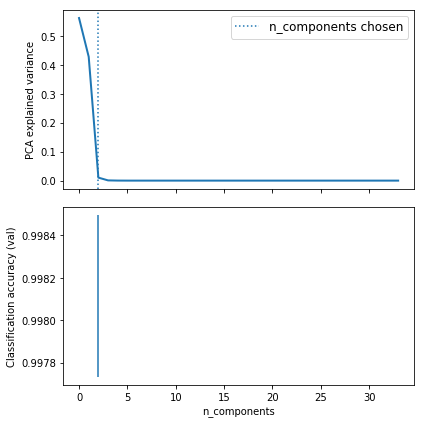

CPU times: user 24.7 s, sys: 312 ms, total: 25 s
Wall time: 6.42 s


In [13]:
%%time



transformer = FunctionTransformer(np.log, validate=True)

scl = StandardScaler()

logistic = SGDClassifier(loss='modified_huber', max_iter=10000, tol=np.exp(-5), random_state=0)

pca = PCA()
pipe = Pipeline(steps=[('standardize', scl), # ('logarithm', transformer), 
                       ('pca', pca), ('logistic', logistic)])

# After having run a larger search: 
'''Best Parameter (CV score=0.765):
{'logistic__alpha': 0.15848931924611143, 'logistic__loss': 'modified_huber', 'logistic__penalty': 'l2', 'pca__n_components': 218}
CPU times: user 44min 51s, sys: 1min 46s, total: 46min 37s
Wall time: 23min 30s

'''
pcan = 218
l_alpha = 0.15848931924611143

param_grid = {
    'pca__n_components': np.arange(b,NCm, a**b),
    'logistic__alpha': np.logspace(-b**b, b**b, a),
    'logistic__loss': ['modified_huber', 'log'], 
    'logistic__penalty': ['l2', 'l1']
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)

search.fit(X, y)

print('Best Parameter (CV score=%0.3f):' % search.best_score_)
print(search.best_params_)

#Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

print(pca.explained_variance_ratio_)


ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()
